In [1]:
import sys
sys.path.insert(0, "./mmdetection")

import os
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

# Check MMDetection installation
from mmdet.apis import set_random_seed

# Imports
from mmdet.apis import set_random_seed

import mmcv
from mmdet.models import build_detector
from mmcv.runner import load_checkpoint
from mmcv.parallel import MMDataParallel
from mmdet.datasets import build_dataloader, build_dataset
from mmdet.apis import single_gpu_test
from mmdet.apis import init_detector, inference_detector, show_result_pyplot

import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import cv2
import json
import random
import numpy as np

1.7.0 True
11.0
GCC 7.3


In [2]:
global_seed = 111

def set_seed(seed=global_seed):
    """Sets the random seeds."""
    set_random_seed(seed, deterministic=False)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

In [3]:
from mmcv import Config

cfg_path = f'models/detector-cascadercnn/job4_cascade_rcnn_x101_32x4d_fpn_1x_coco.py'
model_checkpoint = "models/detector-cascadercnn/epoch_10.pth"

print("Loading weights from:", model_checkpoint)
cfg = Config.fromfile(cfg_path)
model = init_detector(cfg, model_checkpoint, device='cuda:0')

Loading weights from: models/detector-cascadercnn/epoch_10.pth
load checkpoint from local path: models/detector-cascadercnn/epoch_10.pth


/workspace/mmdetection/mmdet/apis/inference.py:47: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [4]:
with open("./dataset/covid19-coco-512-GroupKFold/val_annotations_fold0.json") as f:
    val_ann = json.load(f)
imagepaths = [item['file_name'] for item in val_ann['images'][:9]]

df_annotations = pd.read_csv('./dataset/resized-512/df_train_processed_meta.csv')

In [5]:
def draw_bbox(image,
              box,
              label,
              color,
              label_size = 0.5,
              alpha_box = 0.3,
              alpha_label = 0.6):
    
    overlay_bbox = image.copy()
    overlay_label = image.copy()
    output = image.copy()

    text_width, text_height = cv2.getTextSize(label.upper(),
                                              cv2.FONT_HERSHEY_SIMPLEX, label_size, 1)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                  color, -1)
    cv2.addWeighted(overlay_bbox, alpha_box, output, 1-alpha_box, 0, output)
    
    cv2.rectangle(overlay_label, (box[0], box[1]-7-text_height),
                  (box[0]+text_width+2, box[1]), (0, 0, 0), -1)
    cv2.addWeighted(overlay_label, alpha_label, output, 1-alpha_label, 0, output)
    output = cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                           color, 2)
    cv2.putText(output, label.upper(), (box[0], box[1]-5),
            cv2.FONT_HERSHEY_SIMPLEX, label_size, (255, 255, 255), 1, cv2.LINE_AA)
    return output

/workspace/mmdetection/mmdet/datasets/utils.py:65: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


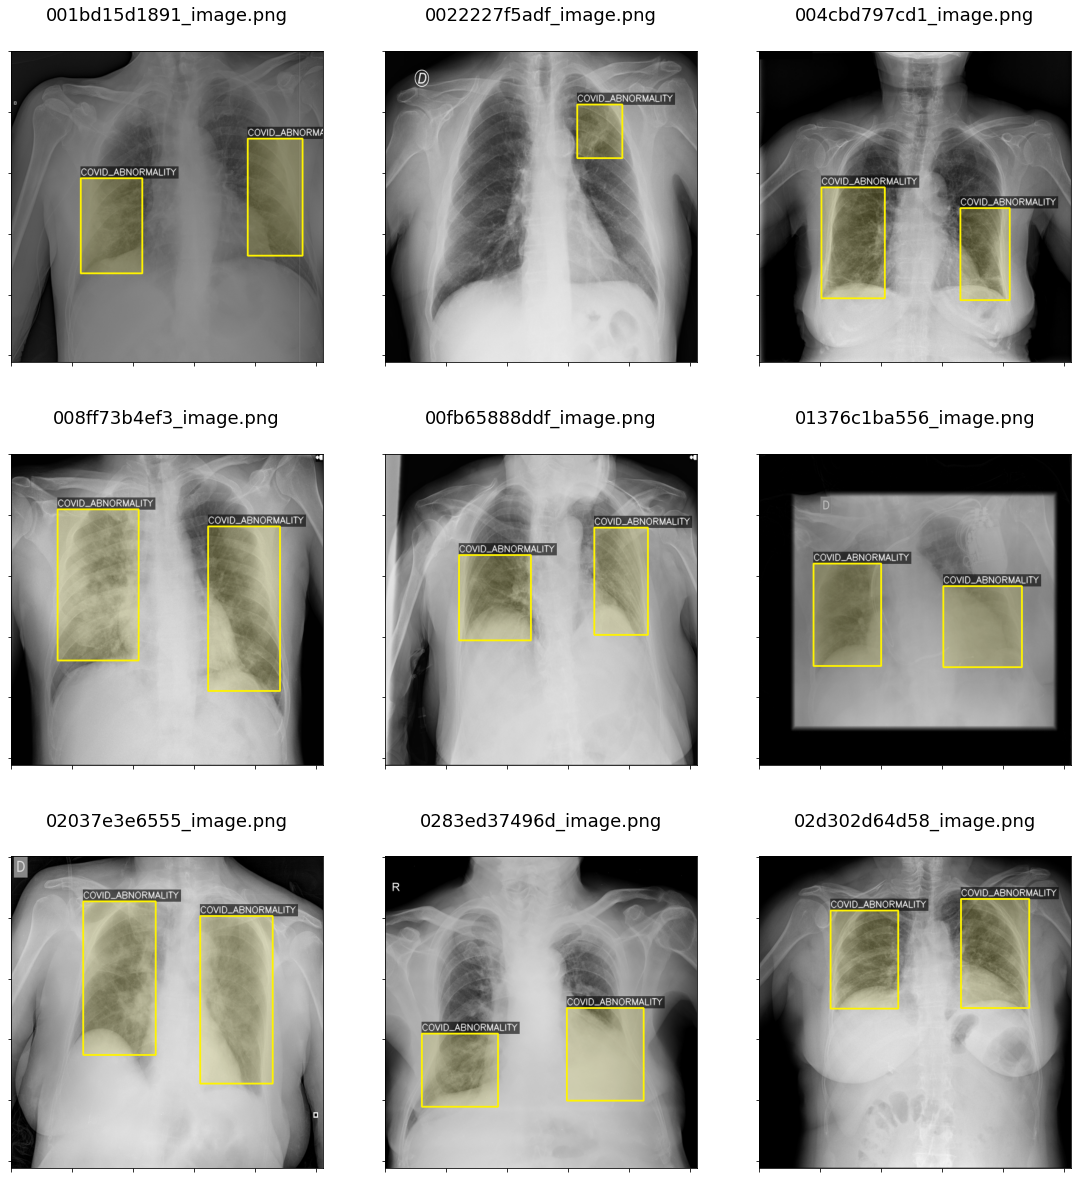

In [6]:
new_size = (512, 512)
imgs_path = "./dataset/resized-512/train"
threshold = 0.45

fig, axes = plt.subplots(3,3, figsize=(19,21))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
axes = axes.ravel()

results_list = []

for idx, img_id in enumerate(imagepaths):
    img_path = os.path.join(imgs_path, img_id)
    img = cv2.imread(img_path)
    result = inference_detector(model, img_path)
    results_filtered = result[0][result[0][:, 4]>threshold]
    bboxes = results_filtered[:, :4]
    scores = results_filtered[:, 4] 
    results_list.append(result[0])
    
    for box in bboxes:
        img = draw_bbox(img, list(np.int_(box)), "Covid_Abnormality",
                        (255, 243, 0))

    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(img_id, size=18, pad=30)
    axes[idx].set_xticklabels([])
    axes[idx].set_yticklabels([])

In [9]:
new_size = (512, 512)
imgs_path = "./dataset/resized-512/train"
threshold = 0.45

detections = []

for image, annotation in zip(val_ann['images'], val_ann["annotations"]):
    img_path = os.path.join(imgs_path, image['file_name'])
    img = cv2.imread(img_path)
    result = inference_detector(model, img_path)
    results_filtered = result[0][result[0][:, 4]>threshold]
    bboxes = results_filtered[:, :4]
    scores = results_filtered[:, 4]

    for bbox, score in zip(bboxes, scores):
        detection = {
            "id": annotation['id'],
            "area": bbox[0] * bbox[1],
            "image_id": annotation["image_id"],
            "bbox": bbox.astype(np.int32).tolist() ,
            "iscrowd": annotation["iscrowd"],
            "score": float(score).round(3)
        }
        detections.append(detection)
    

In [63]:
test_det = {
    "images": val_ann["images"],
    "annotations": detections,
    "categories":val_ann["categories"]
}

In [69]:
class JSONEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.float32):
            return float(obj)
        return json.JSONEncoder.default(self, obj)

with open("covid-19-test-det.json", "w") as fp:
    json.dump(test_det, fp, cls=JSONEncoder)

with open("covid-19-test-gt.json", "w") as fp:
    json.dump(val_ann, fp, cls=JSONEncoder)